In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum
from functools import reduce
import pandas as pd
from pyspark.sql.functions import col, expr, percentile_approx
from pyspark.sql.functions import to_timestamp
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import to_date
from pyspark.sql.functions import avg
import matplotlib.pyplot as plt
import os
from pymongo import MongoClient
from datetime import datetime
import numpy as np

# Start Spark session
spark = SparkSession.builder \
    .appName("OPSData") \
    .config("spark.mongodb.input.uri", "mongodb://localhost/opsd.power_data") \
    .config("spark.mongodb.output.uri", "mongodb://localhost/opsd.power_data") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Optional: reduce log noise
spark.sparkContext.setLogLevel("WARN")


In [2]:
base_path = os.path.expanduser("~/Documents/SparkNotebooks/opsd")
file_name = "time_series_60min_singleindex.csv"

file_path = os.path.join(base_path, file_name)

df = spark.read.csv(file_path, header=True, inferSchema=True)

# Dataset is really wide and can't be viewed properly in notebooks
df.show(5)


+-------------------+-------------------+----------------------------------+------------------------------------+------------------+--------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+-------------------------+----------------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+---------------------------------+----------------------------------+------------------------------------+-----------------+--------------------------+------------------------+---------------------------------+----------------------------------+------------------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+---------------------------------+----------------------------------+------------------------------

In [3]:
df.printSchema()         # See all the columns and data types

root
 |-- utc_timestamp: timestamp (nullable = true)
 |-- cet_cest_timestamp: timestamp (nullable = true)
 |-- AT_load_actual_entsoe_transparency: double (nullable = true)
 |-- AT_load_forecast_entsoe_transparency: double (nullable = true)
 |-- AT_price_day_ahead: double (nullable = true)
 |-- AT_solar_generation_actual: double (nullable = true)
 |-- AT_wind_onshore_generation_actual: double (nullable = true)
 |-- BE_load_actual_entsoe_transparency: double (nullable = true)
 |-- BE_load_forecast_entsoe_transparency: double (nullable = true)
 |-- BE_solar_generation_actual: double (nullable = true)
 |-- BE_wind_generation_actual: double (nullable = true)
 |-- BE_wind_offshore_generation_actual: double (nullable = true)
 |-- BE_wind_onshore_generation_actual: double (nullable = true)
 |-- BG_load_actual_entsoe_transparency: double (nullable = true)
 |-- BG_load_forecast_entsoe_transparency: double (nullable = true)
 |-- BG_solar_generation_actual: double (nullable = true)
 |-- BG_wind_on

In [4]:
df.columns               # Get list of column names

['utc_timestamp',
 'cet_cest_timestamp',
 'AT_load_actual_entsoe_transparency',
 'AT_load_forecast_entsoe_transparency',
 'AT_price_day_ahead',
 'AT_solar_generation_actual',
 'AT_wind_onshore_generation_actual',
 'BE_load_actual_entsoe_transparency',
 'BE_load_forecast_entsoe_transparency',
 'BE_solar_generation_actual',
 'BE_wind_generation_actual',
 'BE_wind_offshore_generation_actual',
 'BE_wind_onshore_generation_actual',
 'BG_load_actual_entsoe_transparency',
 'BG_load_forecast_entsoe_transparency',
 'BG_solar_generation_actual',
 'BG_wind_onshore_generation_actual',
 'CH_load_actual_entsoe_transparency',
 'CH_load_forecast_entsoe_transparency',
 'CH_solar_capacity',
 'CH_solar_generation_actual',
 'CH_wind_onshore_capacity',
 'CH_wind_onshore_generation_actual',
 'CY_load_actual_entsoe_transparency',
 'CY_load_forecast_entsoe_transparency',
 'CY_wind_onshore_generation_actual',
 'CZ_load_actual_entsoe_transparency',
 'CZ_load_forecast_entsoe_transparency',
 'CZ_solar_generation_

In [5]:
# Number of columns
len(df.columns)

300

In [6]:
df.select("utc_timestamp", "IE_load_actual_entsoe_transparency").show(10)

+-------------------+----------------------------------+
|      utc_timestamp|IE_load_actual_entsoe_transparency|
+-------------------+----------------------------------+
|2015-01-01 01:00:00|                              NULL|
|2015-01-01 02:00:00|                            2832.0|
|2015-01-01 03:00:00|                            2678.0|
|2015-01-01 04:00:00|                            2432.0|
|2015-01-01 05:00:00|                            2276.0|
|2015-01-01 06:00:00|                            2173.0|
|2015-01-01 07:00:00|                            2136.0|
|2015-01-01 08:00:00|                            2166.0|
|2015-01-01 09:00:00|                            2215.0|
|2015-01-01 10:00:00|                            2237.0|
+-------------------+----------------------------------+
only showing top 10 rows



In [7]:
# Count rows
df.count()

50401

In [8]:
# Basic stats on a numeric column
df.describe("IE_load_actual_entsoe_transparency").show()

+-------+----------------------------------+
|summary|IE_load_actual_entsoe_transparency|
+-------+----------------------------------+
|  count|                             49837|
|   mean|                3191.2216425547285|
| stddev|                 608.6479345942973|
|    min|                            1790.0|
|    max|                            5018.0|
+-------+----------------------------------+



In [9]:
# Get null counts
nulls = df.select([
    sum(col(c).isNull().cast("int")).alias(c) for c in df.columns
])

# Convert to Pandas and sort by null count
nulls_pd = nulls.toPandas().T
nulls_pd.columns = ['null_count']
nulls_pd = nulls_pd.sort_values(by='null_count', ascending=False)

# Show top 20 columns with most nulls
nulls_pd.head(20)


,null_count
HR_solar_generation_actual,50391
HR_wind_onshore_generation_actual,50379
PT_wind_offshore_generation_actual,47509
PT_wind_generation_actual,47509
PL_solar_generation_actual,46237
HU_solar_generation_actual,41436
SK_wind_onshore_generation_actual,40722
NO_5_wind_onshore_generation_actual,40132
NO_1_wind_onshore_generation_actual,35815
DE_LU_load_forecast_entsoe_transparency,33745


In [10]:
# Show 20 columns with least nulls
nulls_pd.tail(20)

,null_count
BE_load_actual_entsoe_transparency,1
DE_amprion_load_forecast_entsoe_transparency,1
DE_tennet_wind_onshore_generation_actual,1
DE_amprion_load_actual_entsoe_transparency,1
DE_50hertz_load_forecast_entsoe_transparency,1
DE_50hertz_wind_generation_actual,1
DE_50hertz_wind_offshore_generation_actual,1
DE_50hertz_load_actual_entsoe_transparency,1
DE_50hertz_wind_onshore_generation_actual,1
DE_amprion_wind_onshore_generation_actual,1


### Preprocessing

In [11]:
# Drop duplicates
df_no_duplicates = df.dropDuplicates()
df_no_duplicates.count()

50401

In [12]:
from pyspark.sql.functions import col, percentile_approx
from pyspark.sql.types import NumericType

# Function to compute median for a column (using percentile_approx)
def get_median(df, col_name):
    return df.select(percentile_approx(col_name, 0.5)).first()[0]

# Get numeric columns in the DataFrame
numeric_columns = [col for col, dtype in df.dtypes if isinstance(df.schema[col].dataType, NumericType)]

# Compute median values for all numeric columns in parallel
median_values = {}
for c in numeric_columns:
    try:
        median_val = get_median(df, c)
        median_values[c] = median_val
    except Exception as e:
        print(f"Skipping column {c}: {e}")

# Apply the fillna operation for all numeric columns with their respective medians
df_filled = df
for c, median_val in median_values.items():
    df_filled = df_filled.fillna({c: median_val})

df_filled.show(5)  # Show the first 5 rows of the filled DataFrame


+-------------------+-------------------+----------------------------------+------------------------------------+------------------+--------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+-------------------------+----------------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+---------------------------------+----------------------------------+------------------------------------+-----------------+--------------------------+------------------------+---------------------------------+----------------------------------+------------------------------------+---------------------------------+----------------------------------+------------------------------------+--------------------------+---------------------------------+----------------------------------+------------------------------

In [13]:
#Print all DE columns
de_columns = [col for col in df_filled.columns if col.startswith("DE_")]
print(de_columns)

['DE_load_actual_entsoe_transparency', 'DE_load_forecast_entsoe_transparency', 'DE_solar_capacity', 'DE_solar_generation_actual', 'DE_solar_profile', 'DE_wind_capacity', 'DE_wind_generation_actual', 'DE_wind_profile', 'DE_wind_offshore_capacity', 'DE_wind_offshore_generation_actual', 'DE_wind_offshore_profile', 'DE_wind_onshore_capacity', 'DE_wind_onshore_generation_actual', 'DE_wind_onshore_profile', 'DE_50hertz_load_actual_entsoe_transparency', 'DE_50hertz_load_forecast_entsoe_transparency', 'DE_50hertz_solar_generation_actual', 'DE_50hertz_wind_generation_actual', 'DE_50hertz_wind_offshore_generation_actual', 'DE_50hertz_wind_onshore_generation_actual', 'DE_LU_load_actual_entsoe_transparency', 'DE_LU_load_forecast_entsoe_transparency', 'DE_LU_price_day_ahead', 'DE_LU_solar_generation_actual', 'DE_LU_wind_generation_actual', 'DE_LU_wind_offshore_generation_actual', 'DE_LU_wind_onshore_generation_actual', 'DE_amprion_load_actual_entsoe_transparency', 'DE_amprion_load_forecast_entsoe_t

In [14]:
# Parse timestamp
df_filled = df_filled.withColumn("timestamp", to_timestamp("utc_timestamp"))
df_filled = df_filled.drop("utc_timestamp", "cet_cest_timestamp")  # drop original date columns

In [15]:
# Check how the columns split
for col in df.columns:
    print(f"Column: {col}, Split: {col.split('_')}")


Column: utc_timestamp, Split: ['utc', 'timestamp']
Column: cet_cest_timestamp, Split: ['cet', 'cest', 'timestamp']
Column: AT_load_actual_entsoe_transparency, Split: ['AT', 'load', 'actual', 'entsoe', 'transparency']
Column: AT_load_forecast_entsoe_transparency, Split: ['AT', 'load', 'forecast', 'entsoe', 'transparency']
Column: AT_price_day_ahead, Split: ['AT', 'price', 'day', 'ahead']
Column: AT_solar_generation_actual, Split: ['AT', 'solar', 'generation', 'actual']
Column: AT_wind_onshore_generation_actual, Split: ['AT', 'wind', 'onshore', 'generation', 'actual']
Column: BE_load_actual_entsoe_transparency, Split: ['BE', 'load', 'actual', 'entsoe', 'transparency']
Column: BE_load_forecast_entsoe_transparency, Split: ['BE', 'load', 'forecast', 'entsoe', 'transparency']
Column: BE_solar_generation_actual, Split: ['BE', 'solar', 'generation', 'actual']
Column: BE_wind_generation_actual, Split: ['BE', 'wind', 'generation', 'actual']
Column: BE_wind_offshore_generation_actual, Split: ['BE

In [16]:
# Get a list of country codes from the column names
country_codes = set(
    col.split('_')[0] for col in df.columns if len(col.split('_')) > 1 and len(col.split('_')[0]) == 2 and col.split('_')[0].isalpha()
)

print(country_codes)


{'RO', 'FR', 'UA', 'LU', 'SI', 'EE', 'CY', 'GB', 'FI', 'LT', 'DE', 'BG', 'CH', 'ES', 'SE', 'NL', 'SK', 'PL', 'AT', 'PT', 'HU', 'RS', 'LV', 'NO', 'HR', 'BE', 'DK', 'ME', 'CZ', 'IE', 'GR', 'IT'}


In [17]:
# Let's start with german data only (DE)
de_cols = [col for col in df_filled.columns if col.startswith("DE_")]
selected_columns = ["timestamp"] + de_cols
de_df = df_filled.select(*selected_columns)

In [18]:
# Setup MongoDB connection
client = MongoClient("mongodb://localhost:27017/")
collection = client["opsd"]["power_data"]

In [19]:
# Define the fields for generation, capacity, and profile
generation_fields = ["solar_generation", "wind_generation", "wind_onshore_generation", "wind_offshore_generation"]
capacity_fields = ["solar_capacity", "wind_capacity", "wind_offshore_capacity", "wind_onshore_capacity"]
profile_fields = ["solar_profile", "wind_profile", "wind_offshore_profile", "wind_onshore_profile"]

# Define the renaming template for each country (example with 'DE')
rename_template = {
    "load_actual_entsoe_transparency": "consumption",
    "price_day_ahead": "price_day_ahead",
    "load_forecast_entsoe_transparency": "consumption_forecast",
    "solar_capacity": "solar_capacity",
    "solar_generation_actual": "solar_generation",
    "solar_profile": "solar_profile",
    "wind_capacity": "wind_capacity",
    "wind_generation_actual": "wind_generation",
    "wind_profile": "wind_profile",
    "wind_offshore_capacity": "wind_offshore_capacity",
    "wind_offshore_generation_actual": "wind_offshore_generation",
    "wind_offshore_profile": "wind_offshore_profile",
    "wind_onshore_capacity": "wind_onshore_capacity",
    "wind_onshore_generation_actual": "wind_onshore_generation",
    "wind_onshore_profile": "wind_onshore_profile"
}

def row_to_dict(row, country):
    row_dict = row.asDict()

    # Generate dictionaries for generation, capacity, and profile
    generation = {
        k: row_dict.get(k, None)
        for k in generation_fields if k in row_dict
    }
    capacity = {
        k: row_dict.get(k, None)
        for k in capacity_fields if k in row_dict
    }
    profile = {
        k: row_dict.get(k, None)
        for k in profile_fields if k in row_dict
    }

    # Return the structured dictionary to insert into MongoDB
    return {
        "timestamp": row_dict.get("timestamp", None),
        "country": country,  # Dynamic country
        "consumption": row_dict.get("consumption", None),
        "consumption_forecast": row_dict.get("consumption_forecast", None),
        "price_day_ahead": row_dict.get("price_day_ahead", None),
        "generation": generation,
        "capacity": capacity,
        "profile": profile
    }

# Only process country code 'DE' for testing
country = 'DE'

# Filter columns that start with the country code 'DE'
country_columns = [col for col in df_filled.columns if col.startswith(f"{country}_")]
print(country_columns)

# Create a dynamic renaming map for the country
rename_map = {f"{country}_{key}": f"{value}" for key, value in rename_template.items()}
print(rename_map)

# Filter the rename map to only include columns in the country-specific DataFrame
rename_map = {old: new for old, new in rename_map.items() if old in country_columns}
print(rename_map)

# Select columns for the current country and rename them based on the rename map
country_df = df_filled.select(*country_columns)
for old_col, new_col in rename_map.items():
    country_df = country_df.withColumnRenamed(old_col, new_col)
    print(f"Renamed {old_col} to {new_col}")
    
# Debugging: Show the DataFrame schema and the first few rows after renaming
country_df.printSchema()
country_df.show(5)

# Convert to an RDD and apply the row_to_dict function to structure the data
rdd_docs = country_df.rdd.map(lambda row: row_to_dict(row, country))

# Collect the data to insert into MongoDB
data_to_insert = rdd_docs.collect()

# Insert into MongoDB if there is data for this country
if data_to_insert:
    collection.insert_many(data_to_insert)
    print(f"Data for {country} inserted successfully.")
else:
    print(f"No data found for {country}.")


['DE_load_actual_entsoe_transparency', 'DE_load_forecast_entsoe_transparency', 'DE_solar_capacity', 'DE_solar_generation_actual', 'DE_solar_profile', 'DE_wind_capacity', 'DE_wind_generation_actual', 'DE_wind_profile', 'DE_wind_offshore_capacity', 'DE_wind_offshore_generation_actual', 'DE_wind_offshore_profile', 'DE_wind_onshore_capacity', 'DE_wind_onshore_generation_actual', 'DE_wind_onshore_profile', 'DE_50hertz_load_actual_entsoe_transparency', 'DE_50hertz_load_forecast_entsoe_transparency', 'DE_50hertz_solar_generation_actual', 'DE_50hertz_wind_generation_actual', 'DE_50hertz_wind_offshore_generation_actual', 'DE_50hertz_wind_onshore_generation_actual', 'DE_LU_load_actual_entsoe_transparency', 'DE_LU_load_forecast_entsoe_transparency', 'DE_LU_price_day_ahead', 'DE_LU_solar_generation_actual', 'DE_LU_wind_generation_actual', 'DE_LU_wind_offshore_generation_actual', 'DE_LU_wind_onshore_generation_actual', 'DE_amprion_load_actual_entsoe_transparency', 'DE_amprion_load_forecast_entsoe_t

In [20]:
# Loop through each country code
for country in country_codes:
    # Filter columns that start with the country code
    country_columns = [col for col in df.columns if col.startswith(f"{country}_")]

    # Create a dynamic renaming map for the country
    rename_map = {f"{country}_{key}": f"{country}_{value}" for key, value in rename_template.items()}

    # Filter the rename map to only include columns in the country-specific DataFrame
    rename_map = {old: new for old, new in rename_map.items() if old in country_columns}

    # Select columns for the current country and rename them based on the rename map
    country_df = df.select(*country_columns)
    for old_col, new_col in rename_map.items():
        country_df = country_df.withColumnRenamed(old_col, new_col)

    # Convert to an RDD and apply the row_to_dict function to structure the data
    rdd_docs = country_df.rdd.map(lambda row: row_to_dict(row, country))

    # Collect the data to insert into MongoDB
    data_to_insert = rdd_docs.collect()

    # Insert into MongoDB if there is data for this country
    if data_to_insert:
        collection.insert_many(data_to_insert)
        print(f"Data for {country} inserted successfully.")
    else:
        print(f"No data found for {country}.")

Data for RO inserted successfully.
Data for FR inserted successfully.
Data for UA inserted successfully.
Data for LU inserted successfully.
Data for SI inserted successfully.
Data for EE inserted successfully.
Data for CY inserted successfully.
Data for GB inserted successfully.
Data for FI inserted successfully.
Data for LT inserted successfully.
Data for DE inserted successfully.
Data for BG inserted successfully.
Data for CH inserted successfully.
Data for ES inserted successfully.
Data for SE inserted successfully.
Data for NL inserted successfully.
Data for SK inserted successfully.
Data for PL inserted successfully.
Data for AT inserted successfully.
Data for PT inserted successfully.
Data for HU inserted successfully.
Data for RS inserted successfully.
Data for LV inserted successfully.
Data for NO inserted successfully.
Data for HR inserted successfully.
Data for BE inserted successfully.
Data for DK inserted successfully.
Data for ME inserted successfully.
Data for CZ inserted

### Data to MongoDB

In [21]:
# Rename columns for easier access
rename_map = {
    "DE_load_actual_entsoe_transparency": "consumption",
    "DE_LU_price_day_ahead": "price_day_ahead",
    "DE_load_forecast_entsoe_transparency": "consumption_forecast",
    "DE_solar_capacity": "solar_capacity",
    "DE_solar_generation_actual": "solar_generation",
    "DE_solar_profile": "solar_profile",
    "DE_wind_capacity": "wind_capacity",
    "DE_wind_generation_actual": "wind_generation",
    "DE_wind_profile": "wind_profile",
    "DE_wind_offshore_capacity": "wind_offshore_capacity",
    "DE_wind_offshore_generation_actual": "wind_offshore_generation",
    "DE_wind_offshore_profile": "wind_offshore_profile",
    "DE_wind_onshore_capacity": "wind_onshore_capacity",
    "DE_wind_onshore_generation_actual": "wind_onshore_generation",
    "DE_wind_onshore_profile": "wind_onshore_profile",
    "DE_50hertz_load_actual_entsoe_transparency": "consumption_50hertz",
    "DE_50hertz_wind_onshore_generation_actual": "wind_onshore_50hertz",
    "DE_LU_load_actual_entsoe_transparency": "consumption_LU",
    "DE_LU_load_forecast_entsoe_transparency": "consumption_forecast_LU",
    "DE_LU_solar_generation_actual": "solar_generation_LU",
    "DE_LU_wind_generation_actual": "wind_generation_LU",
    "DE_LU_wind_offshore_generation_actual": "wind_offshore_LU",
    "DE_LU_wind_onshore_generation_actual": "wind_onshore_LU",
    "DE_amprion_load_actual_entsoe_transparency": "consumption_amprion",
    "DE_amprion_load_forecast_entsoe_transparency": "consumption_forecast_amprion",
    "DE_amprion_solar_generation_actual": "solar_amprion",
    "DE_amprion_wind_generation_actual": "wind_amprion",
    "DE_tennet_load_actual_entsoe_transparency": "consumption_tennet",
    "DE_tennet_load_forecast_entsoe_transparency": "consumption_forecast_tennet",
    "DE_tennet_solar_generation_actual": "solar_tennet",
    "DE_tennet_wind_generation_actual": "wind_tennet",
    "DE_tennet_wind_offshore_generation_actual": "wind_offshore_tennet",
    "DE_tennet_wind_onshore_generation_actual": "wind_onshore_tennet",
    "DE_transnetbw_load_actual_entsoe_transparency": "consumption_transnetbw",
    "DE_transnetbw_load_forecast_entsoe_transparency": "consumption_forecast_transnetbw",
    "DE_transnetbw_solar_generation_actual": "solar_transnetbw",
    "DE_transnetbw_wind_onshore_generation_actual": "wind_onshore_transnetbw"
}

for old_col, new_col in rename_map.items():
    de_df = de_df.withColumnRenamed(old_col, new_col)

In [22]:
# Convert rows to dictionarys for MongoDB
# Define the fields to extract for generation, capacity, and profile
generation_fields = ["solar_generation", "wind_generation", "wind_onshore_generation", "wind_offshore_generation"]  # extend this list
capacity_fields = ["solar_capacity", "wind_capacity", "wind_offshore_capacity", "wind_onshore_capacity"]
profile_fields = ["solar_profile", "wind_profile", "wind_offshore_profile", "wind_onshore_profile"]

def row_to_dict(row):
    row_dict = row.asDict()
    generation = {
        k: row_dict.get(k, None)
        for k in generation_fields if k in row_dict
    }
    capacity = {
        k: row_dict.get(k, None)
        for k in capacity_fields if k in row_dict
    }
    profile = {
        k: row_dict.get(k, None)
        for k in profile_fields if k in row_dict
    }
    return {
        "timestamp": row_dict["timestamp"],
        "country": "DE",
        "consumption": row_dict.get("consumption", None),
        "consumption_forecast": row_dict.get("consumption_forecast", None),
        "price_day_ahead": row_dict.get("price_day_ahead", None),
        "generation": generation,
        "capacity": capacity,
        "profile": profile       
    }

rdd_docs = de_df.rdd.map(row_to_dict)

In [23]:
# Setup MongoDB connection
client = MongoClient("mongodb://localhost:27017/")
collection = client["opsd"]["power_data"]

In [25]:
from pymongo.errors import BulkWriteError

# Convert the PySpark DataFrame to a list of dictionaries
documents = de_df.rdd.map(lambda row: row.asDict()).collect()

try:
    for i in range(0, len(documents), 1000):  # batch of 1000
        collection.insert_many(documents[i:i+1000])
except BulkWriteError as bwe:
    print("Bulk write error:", bwe.details)

### Data from MongoDB

In [29]:
from pyspark.sql.functions import avg, to_date, col  # Ensure avg, to_date, and col are correctly imported

# Read from MongoDB
df_read = spark.read.format("mongo").load()

# Extract the 'timestamp' and 'wind_generation' columns, and convert 'timestamp' to a date
df_filtered = df_read.select(
    "timestamp",
    "generation.wind_generation"
).withColumn("date", to_date(col("timestamp")))

# Calculate daily average of wind generation
daily_avg_df = df_filtered.groupBy("date").agg(
    avg("wind_generation").alias("avg_wind_generation")
)
# Sort by date
daily_avg_df = daily_avg_df.orderBy("date")

# Show the daily averages
daily_avg_df.show(20)

+----------+-------------------+
|      date|avg_wind_generation|
+----------+-------------------+
|      NULL|  11548.45759012718|
|2015-01-01| 11811.238095238095|
|2015-01-02|          24670.125|
|2015-01-03| 20597.541666666668|
|2015-01-04|           16706.25|
|2015-01-05|          10783.125|
|2015-01-06|           3653.875|
|2015-01-07|  8599.458333333334|
|2015-01-08|          16999.875|
|2015-01-09|           26895.75|
|2015-01-10| 25876.666666666668|
|2015-01-11| 26227.666666666668|
|2015-01-12| 26347.916666666668|
|2015-01-13| 22571.583333333332|
|2015-01-14| 17446.333333333332|
|2015-01-15| 21736.083333333332|
|2015-01-16| 13659.208333333334|
|2015-01-17|  5160.416666666667|
|2015-01-18|  5950.416666666667|
|2015-01-19|           1672.875|
+----------+-------------------+
only showing top 20 rows



### Plotting

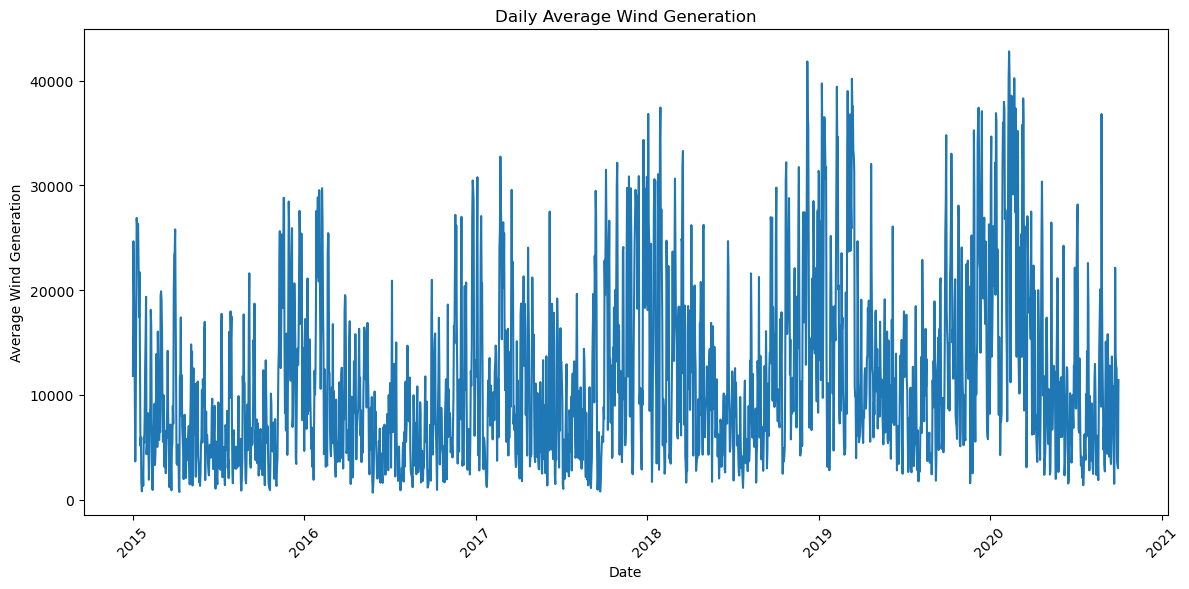

In [31]:
import seaborn as sns

# Convert the PySpark DataFrame to a Pandas DataFrame
daily_avg_pd = daily_avg_df.toPandas()

# Create the seaborn line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='avg_wind_generation', data=daily_avg_pd)

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Average Wind Generation')
plt.title('Daily Average Wind Generation')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


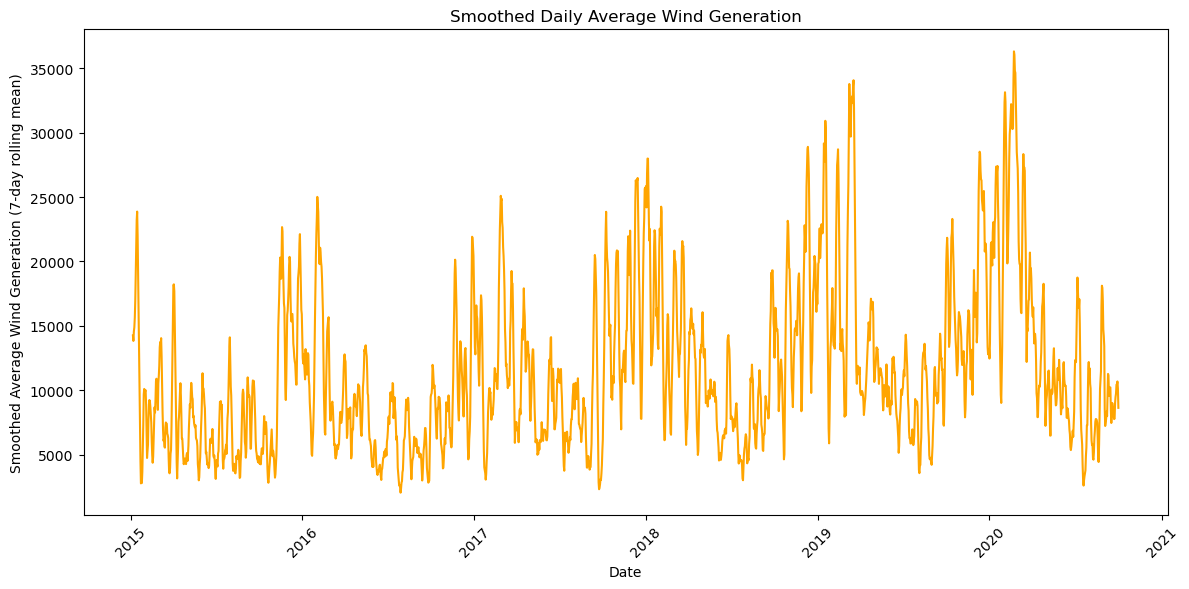

In [32]:
# Calculate a 7-day rolling average for smoother lines
daily_avg_pd['rolling_avg'] = daily_avg_pd['avg_wind_generation'].rolling(window=7).mean()

# Plot the smoothed line (rolling average)
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='rolling_avg', data=daily_avg_pd, color='orange')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Smoothed Average Wind Generation (7-day rolling mean)')
plt.title('Smoothed Daily Average Wind Generation')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.sql import functions as F

# Extract year and month from the 'date' column
df_filtered = df_filtered.withColumn("year", F.year("date")).withColumn("month", F.month("date"))

# Calculate total wind generation by year and month
monthly_total_df = df_filtered.groupBy("year", "month").agg(
    F.sum("wind_generation").alias("total_wind_generation")
)

# Sort by total wind generation in descending order
monthly_total_df = monthly_total_df.orderBy("total_wind_generation", ascending=False)

# Show the results
monthly_total_df.show(20)


In [ ]:
# Convert to Pandas DataFrame for easier plotting
monthly_total_pd = monthly_total_df.toPandas()

# Create a bar plot for the months with the highest wind generation
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='total_wind_generation', data=monthly_total_pd, hue='year')

# Set plot labels and title
plt.xlabel('Month')
plt.ylabel('Total Wind Generation')
plt.title('Total Wind Generation by Month')

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
# Read solar_generation data from MongoDB (assuming similar structure as wind_generation)
df_solar = spark.read.format("mongo").load()

# Extract the necessary columns for solar generation
df_solar_filtered = df_solar.select(
    "timestamp",
    "generation.solar_generation"
).withColumn("date", to_date(col("timestamp")))

# Join the solar generation data with the wind generation data on 'date'
df_combined = df_filtered.join(
    df_solar_filtered,
    on="date",
    how="inner"  # Inner join ensures we only keep matching dates
)

In [ ]:
# Calculate total energy generation by adding wind_generation and solar_generation
df_combined = df_combined.withColumn(
    "total_generation",
    col("wind_generation") + col("solar_generation")
)


In [ ]:
# Fetch consumption data from MongoDB (assuming it's structured similarly)
df_consumption = spark.read.format("mongo").load()

# Extract the necessary columns for consumption
df_consumption_filtered = df_consumption.select(
    "timestamp",
    "consumption"
).withColumn("date", to_date(col("timestamp")))

# Join the consumption data with the combined generation data on 'date'
df_final = df_combined.join(
    df_consumption_filtered,
    on="date",
    how="inner"  # We want to match the same date
)


In [ ]:
# Calculate if total generation meets or exceeds consumption
df_final = df_final.withColumn(
    "generation_vs_consumption",
    col("total_generation") - col("consumption")
)

# Group by date and calculate daily totals for generation, consumption, and the difference
daily_comparison_df = df_final.groupBy("date").agg(
    sum("total_generation").alias("total_generation"),
    sum("consumption").alias("total_consumption"),
    sum("generation_vs_consumption").alias("net_generation")
)

# Sort by date
daily_comparison_df = daily_comparison_df.orderBy("date")

# Show the results
daily_comparison_df.show(20)


In [ ]:
# Convert to Pandas DataFrame for visualization
daily_comparison_pd = daily_comparison_df.toPandas()

# Plot the comparison of total generation vs total consumption
plt.figure(figsize=(12, 6))

# Plot both total generation and total consumption
sns.lineplot(x='date', y='total_generation', data=daily_comparison_pd, label='Total Generation', color='blue')
sns.lineplot(x='date', y='total_consumption', data=daily_comparison_pd, label='Total Consumption', color='red')

# Add a title and labels
plt.title('Total Energy Generation vs Consumption')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')

# Display legend
plt.legend()

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
# Extract year and month from the 'date' column
df_final = df_final.withColumn("year", F.year("date")).withColumn("month", F.month("date"))

# Aggregate by month and year
monthly_summary_df = df_final.groupBy("year", "month").agg(
    F.sum("total_generation").alias("monthly_generation"),
    F.sum("consumption").alias("monthly_consumption"),  # Corrected column name
    F.sum("generation_vs_consumption").alias("net_generation")
)

# Calculate renewable energy percentage for each month
monthly_summary_df = monthly_summary_df.withColumn(
    "renewable_energy_percentage",
    (col("monthly_generation") / col("monthly_consumption")) * 100
)

# Sort by year and month
monthly_summary_df = monthly_summary_df.orderBy("year", "month")

# Show the monthly summary
monthly_summary_df.show()


In [ ]:
# Convert to Pandas DataFrame for easier plotting
monthly_summary_pd = monthly_summary_df.toPandas()

# Combine year and month into a single column for better x-axis labels
monthly_summary_pd['month_year'] = monthly_summary_pd['month'].astype(str) + '-' + monthly_summary_pd['year'].astype(str)

# Plot the renewable energy percentage month by month
plt.figure(figsize=(12, 6))
sns.barplot(x='month_year', y='renewable_energy_percentage', data=monthly_summary_pd, color='green')

# Set plot labels and title
plt.xlabel('Month-Year')
plt.ylabel('Renewable Energy Percentage')
plt.title('Monthly Renewable Energy Contribution to Consumption')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Display the plot
plt.tight_layout()
plt.show()
